# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите модель ближайших соседей для&nbsp;произвольно заданного гиперпараметра $K$. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик.
5. Постройте модель и оцените качество модели с&nbsp;использованием кросс-валидации. Проведите эксперименты с&nbsp;тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра $K$ с&nbsp;использованием `GridSearchCV` и кросс-валидации.
7. Повторите пункт&nbsp;4 для&nbsp;найденного оптимального значения гиперпараметра $K$. Сравните качество полученной модели с&nbsp;качеством модели, полученной в&nbsp;пункте&nbsp;4.
8. Постройте кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются метрологические данные с&nbsp;метеостанции HI-SEAS (Hawaii Space Exploration Analog and Simulation) за&nbsp;четыре месяца (с&nbsp;сентября по&nbsp;декабрь 2016&nbsp;года)<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("./SolarPrediction.csv")

Преобразуем временные колонки в соответствующий временной формат:

In [4]:
data["Time"] = (pd
                    .to_datetime(data["UNIXTime"], unit="s", utc=True)
                    .dt.tz_convert("Pacific/Honolulu")).dt.time

data["TimeSunRise"] = (pd
                       .to_datetime(data["TimeSunRise"],
                                    infer_datetime_format=True)
                       .dt.time)

data["TimeSunSet"] = (pd
                      .to_datetime(data["TimeSunSet"],
                                   infer_datetime_format=True)
                      .dt.time)

data = data.rename({"WindDirection(Degrees)": "WindDirection"},
                   axis=1)

Проверим полученные типы:

In [5]:
data.dtypes

UNIXTime           int64
Data              object
Time              object
Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
TimeSunRise       object
TimeSunSet        object
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [6]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Очевидно, что все эти временные характеристики в&nbsp;таком виде нам не&nbsp;особо интересны. Преобразуем все нечисловые столбцы в&nbsp;числовые. В&nbsp;целом колонка `UNIXTime` нам не&nbsp;интересна, дата скорее интереснее в&nbsp;виде дня в&nbsp;году. Время измерения может быть интересно в&nbsp;двух видах: просто секунды с&nbsp;полуночи, и время, нормализованное относительно рассвета и заката. Для&nbsp;преобразования времени в&nbsp;секунды используем следующий метод<cite data-cite="so:dttseconds"></cite>:

In [7]:
def time_to_second(t):
    return ((datetime.combine(datetime.min, t) - datetime.min)
            .total_seconds())

In [8]:
df = data.copy()

timeInSeconds = df["Time"].map(time_to_second)

sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)

df = df.drop(["UNIXTime", "Data", "Time",
              "TimeSunRise", "TimeSunSet"], axis=1)

df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [9]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

С&nbsp;такими данными уже можно работать. Проверим размер набора данных:

In [10]:
df.shape

(32686, 7)

Проверим основные статистические характеристики набора данных:

In [11]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0.482959
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.602432
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,-0.634602
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,-0.040139
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0.484332
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.006038
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.566061


Проверим наличие пропусков в&nbsp;данных:

In [12]:
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [13]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]

In [14]:
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [15]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


Предобработаем данные, чтобы методы работали лучше:

In [16]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

c:\users\matsh\onedrive\428a~1\3188~1\2425f~1\9b69~1\lab4\venv~1\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\matsh\onedrive\428a~1\3188~1\2425f~1\9b69~1\lab4\venv~1\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04
mean,5.565041e-16,2.904952e-14,1.391260e-17,6.956302e-17,-9.738822e-17,5.217226e-18
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.758117e+00,-4.259540e+00,-2.578560e+00,-1.724255e+00,-1.788859e+00,-1.855112e+00
25%,-8.229646e-01,-4.184734e-01,-7.316829e-01,-7.366250e-01,-8.233591e-01,-8.683240e-01
50%,-1.779139e-01,1.302504e-01,3.841386e-01,5.062367e-02,-1.787376e-01,2.279483e-03
75%,6.283995e-01,6.789742e-01,8.458578e-01,4.307058e-01,4.658840e-01,8.682924e-01
max,3.208603e+00,2.508053e+00,1.076717e+00,2.602741e+00,9.814329e+00,1.797910e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Напишем функцию, которая считает метрики построенной модели:

In [19]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Попробуем метод ближайших соседей с&nbsp;гиперпараметром $K=5$:

In [20]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

Проверим метрики построенной модели:

In [21]:
test_model(reg_5)

mean_absolute_error: 55.39857905041605
median_absolute_error: 4.017000000000004
r2_score: 0.8677873476991447


Видно, что средние ошибки не&nbsp;очень показательны для&nbsp;одной модели, они больше подходят для&nbsp;сравнения разных моделей. В&nbsp;тоже время коэффициент детерминации неплох сам по&nbsp;себе, в&nbsp;данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Проверим различные стратегии кросс-валидации. Для&nbsp;начала посмотрим классический K-fold:

In [22]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.83276085 0.5984654  0.83547149 0.75974839 0.76407458 0.81422383
 0.85420738 0.79432111 0.74927049 0.28234327]
0.7284886763598686 ± 0.16383980384698185


In [23]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.86645745 0.87359216 0.86201671 0.87253355 0.86825249 0.87149987
 0.86931511 0.86595468 0.86938791 0.867287  ]
0.8686296919477157 ± 0.0032664937392509145


In [24]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.87288289 0.86965989 0.87846365 0.87005449 0.86511118 0.87199795
 0.87614293 0.87572756 0.87447917 0.86520971]
0.8719729406086248 ± 0.00427294746868573


## Подбор гиперпараметра $K$

Введем список настраиваемых параметров:

In [25]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Запустим подбор параметра:

In [26]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 5}

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

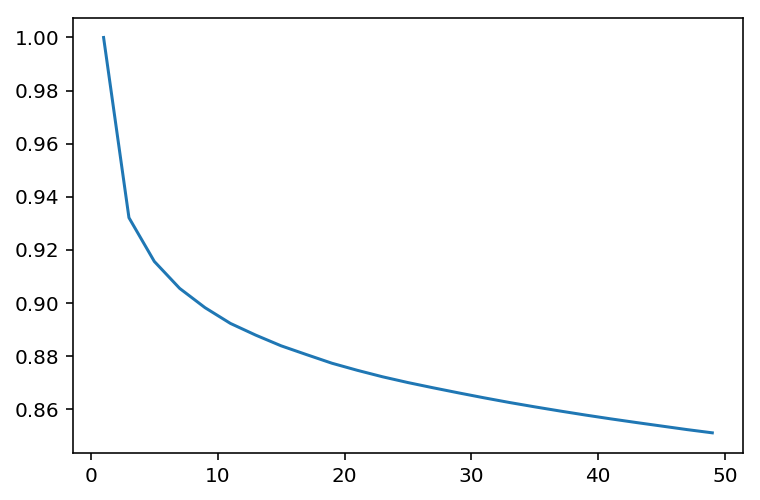

In [27]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для&nbsp;$K=1$ на&nbsp;тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На&nbsp;тестовом наборе данных картина сильно интереснее:

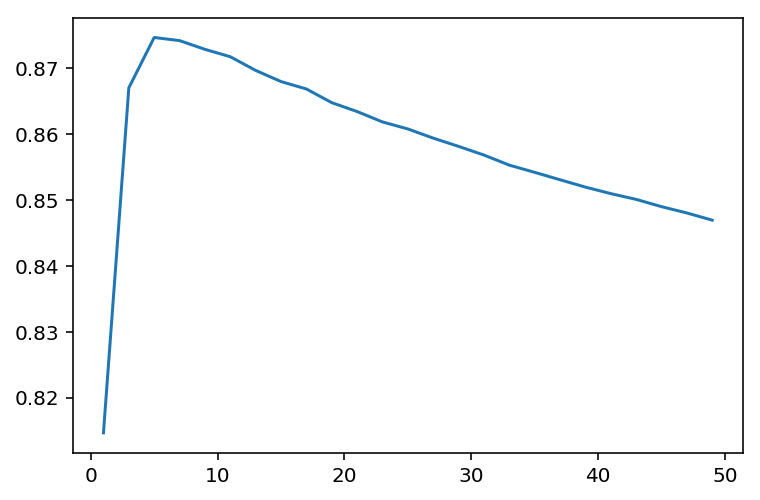

In [28]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Выходит, что сначала соседей слишком мало (высоко влияние выбросов), а затем количество соседей постепенно становится слишком велико, и среднее значение по&nbsp;этим соседям всё больше и больше оттягивает значение от&nbsp;истинного.

Проверим получившуюся модель:

In [29]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 55.39857905041605
median_absolute_error: 4.017000000000004
r2_score: 0.8677873476991447


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод и так показал достаточно хороший результат для&nbsp;данной выборки.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

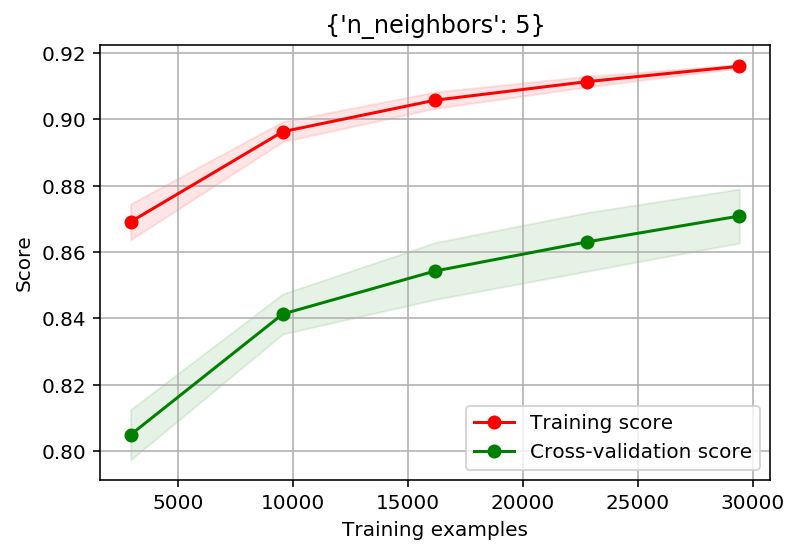

In [31]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [32]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

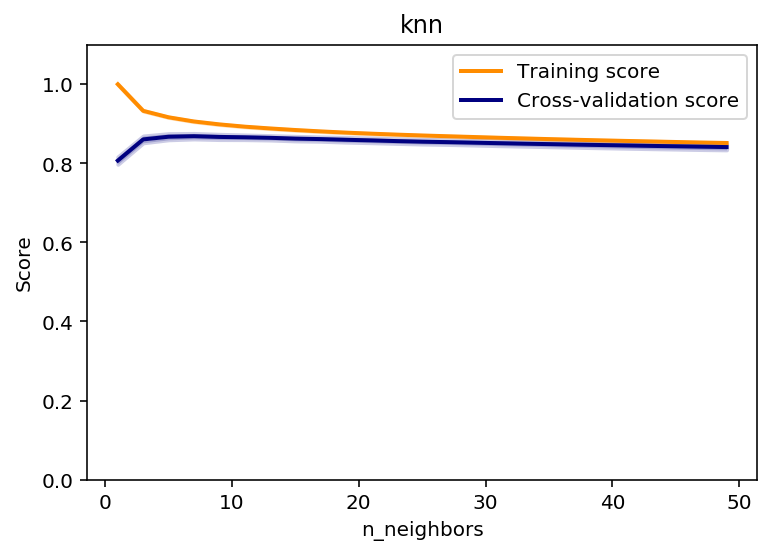

In [33]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");